<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/signal_kalman_nifty_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pykalman --q
!pip install yfinance --q
#!pip install pandas-ta==0.2.45b

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
#Importing dependencies#
from pykalman import KalmanFilter
import numpy as np
import pylab as pl
import pandas as pd
import yfinance as yf
from scipy import poly1d
from datetime import datetime
#import pandas_ta as ta
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
pd.options.mode.chained_assignment = None

In [4]:
#ticker = pd.read_csv('https://raw.githubusercontent.com/anirbanghoshsbi/data/main/ind_niftybanklist.csv')

In [5]:
ticker = pd.read_csv('https://raw.githubusercontent.com/anirbanghoshsbi/data/main/ind_nifty50list.csv')
START = "2013-01-01"

In [6]:
nifty=yf.download('^nsei',start=START)

[*********************100%***********************]  1 of 1 completed


In [ ]:
ticker

In [8]:
def find_name(df, column, name_to_search):
    result = df[df[column] == name_to_search].index
    if len(result) > 0:
        return result[0]
    else:
        return None

In [9]:
searched_name = 'RELIANCE'
index_reliance = find_name(ticker, 'Symbol', searched_name)
searched_name = 'TCS'
index_tcs = find_name(ticker, 'Symbol', searched_name)
searched_name = 'INFY'
index_infy = find_name(ticker, 'Symbol', searched_name)
searched_name = 'HINDUNILVR'
index_hul = find_name(ticker, 'Symbol', searched_name)
searched_name = 'ITC'
index_itc = find_name(ticker, 'Symbol', searched_name)
searched_name = 'HDFCBANK'
index_hdfcbank = find_name(ticker, 'Symbol', searched_name)
searched_name = 'ICICIBANK'
index_icicibank = find_name(ticker, 'Symbol', searched_name)

In [10]:
index_reliance,index_tcs,index_hdfcbank,index_icicibank

(36, 41, 16, 22)

In [ ]:
lst=[]
for i in range(len(ticker)):
  
  dfi = yf.download(str(ticker.Symbol.iloc[i])+'.ns', start=START)
  df = dfi[['Adj Close']]
  
  f = KalmanFilter(transition_matrices = [1],
                    observation_matrices = [1],
                    initial_state_mean = 0,
                    initial_state_covariance = 1,
                    observation_covariance = 1,
                    transition_covariance = 0.0001)
  mean, cov = f.filter(df['Adj Close'].values)
  mean, std = mean.squeeze(), np.std(cov.squeeze())
  var = 'kalman' 
  df[var]=df['Adj Close'].values - mean
  
  lst.append(df)

In [12]:
nlst=[]
for i in range(len(ticker)):
  nlst.append(lst[i].kalman)  

In [13]:
df_kalman = pd.DataFrame(nlst).T

In [14]:
namelist =[]
for i in range(1,len(ticker)+1):
  namelist.append('kalman_'+str(i))
  
df_kalman.columns = namelist

In [15]:
def calculate_macd(dataframe):
    column_names = dataframe.columns.tolist()
    macd_dataframes = [dataframe]

    for variable in column_names:
        macd_column = 'macd' + variable
        macd_signal_column = 'macd'+'signal' + variable
        macd_histogram_column = 'hist' + variable
        
        macd = dataframe[variable].ewm(span=26, adjust=False).mean() - dataframe[variable].ewm(span=50, adjust=False).mean()
        macd_signal = macd.ewm(span=18, adjust=False).mean()
        macd_histogram = macd - macd_signal
        
        new_dataframe = pd.DataFrame({macd_column: macd, 
                                      macd_signal_column: macd_signal, 
                                      macd_histogram_column: macd_histogram})
        
        macd_dataframes.append(new_dataframe)
    
    result_dataframe = pd.concat(macd_dataframes, axis=1)
    return result_dataframe


In [16]:
final_kalman=calculate_macd(df_kalman)

In [17]:
final_kalman.tail(2)

,kalman_1,kalman_2,kalman_3,kalman_4,kalman_5,kalman_6,kalman_7,kalman_8,kalman_9,kalman_10,...,histkalman_47,macdkalman_48,macdsignalkalman_48,histkalman_48,macdkalman_49,macdsignalkalman_49,histkalman_49,macdkalman_50,macdsignalkalman_50,histkalman_50
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-09,12.327343,194.516771,116.864916,747.024076,582.608938,28.214642,17.575249,57.982100,679.230858,-10.583824,...,6.320304,-6.682125,-7.179852,0.497727,69.201070,43.517108,25.683962,8.314272,6.797801,1.516471
2023-06-12,19.283505,206.639964,115.157581,765.579902,636.759716,27.438878,29.478964,60.226788,693.758498,-19.685966,...,4.844255,-6.683881,-7.127644,0.443763,75.912704,46.927171,28.985533,8.083242,6.933111,1.150131


In [18]:
features = final_kalman.columns.tolist()

In [19]:
feats_set1=[feats for feats in features if feats.startswith('hist')]

In [20]:
final_dataframe=final_kalman[feats_set1]

In [21]:
final_dataframe.head(2)

,histkalman_1,histkalman_2,histkalman_3,histkalman_4,histkalman_5,histkalman_6,histkalman_7,histkalman_8,histkalman_9,histkalman_10,...,histkalman_41,histkalman_42,histkalman_43,histkalman_44,histkalman_45,histkalman_46,histkalman_47,histkalman_48,histkalman_49,histkalman_50
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-02,-0.667006,-2.21795,-1.246592,-7.369045,-0.692372,-0.47276,-0.323956,-1.477394,-1.082725,-2.0192,...,-1.785604,-2.664583,-0.617602,-1.58529,-0.078152,-0.955621,-1.387411,-0.417454,-9.899713,-0.726066


In [22]:
solution=np.sign(final_dataframe)

In [23]:
solution['final']=solution.sum(axis=1)

In [24]:
solution['histkalman_'+str(index_reliance+1)]=solution['histkalman_'+str(index_reliance+1)]*25

In [25]:
solution['histkalman_'+str(index_hdfcbank+1)]=solution['histkalman_'+str(index_hdfcbank+1)]*10

In [26]:
solution['histkalman_'+str(index_tcs+1)]=solution['histkalman_'+str(index_tcs+1)]*15

In [27]:
solution['histkalman_'+str(index_icicibank+1)]=solution['histkalman_'+str(index_icicibank+1)]*10

In [28]:
solution['histkalman_'+str(index_hul+1)]=solution['histkalman_'+str(index_hul+1)]*12
solution['histkalman_'+str(index_itc+1)]=solution['histkalman_'+str(index_itc+1)]*10

In [29]:
solution.tail(2)

,histkalman_1,histkalman_2,histkalman_3,histkalman_4,histkalman_5,histkalman_6,histkalman_7,histkalman_8,histkalman_9,histkalman_10,...,histkalman_42,histkalman_43,histkalman_44,histkalman_45,histkalman_46,histkalman_47,histkalman_48,histkalman_49,histkalman_50,final
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-09,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,1.0,...,15.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,24.0
2023-06-12,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,1.0,...,15.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,24.0


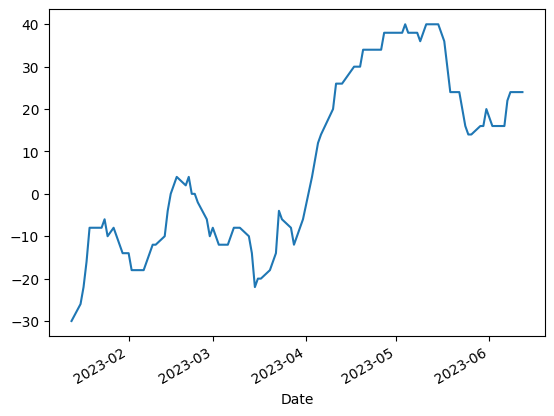

In [30]:
solution.final[-100:].plot();

In [31]:
solution['avg_mov']=solution['final'].rolling(window=10).mean()
nifty['avg_mov']=nifty['Adj Close'].rolling(window=22).mean()

In [32]:
l=1400

In [33]:
nifty['spread']=nifty['Close']-nifty['avg_mov']

In [34]:
nifty=nifty[-l:]
solution=solution[-l:]

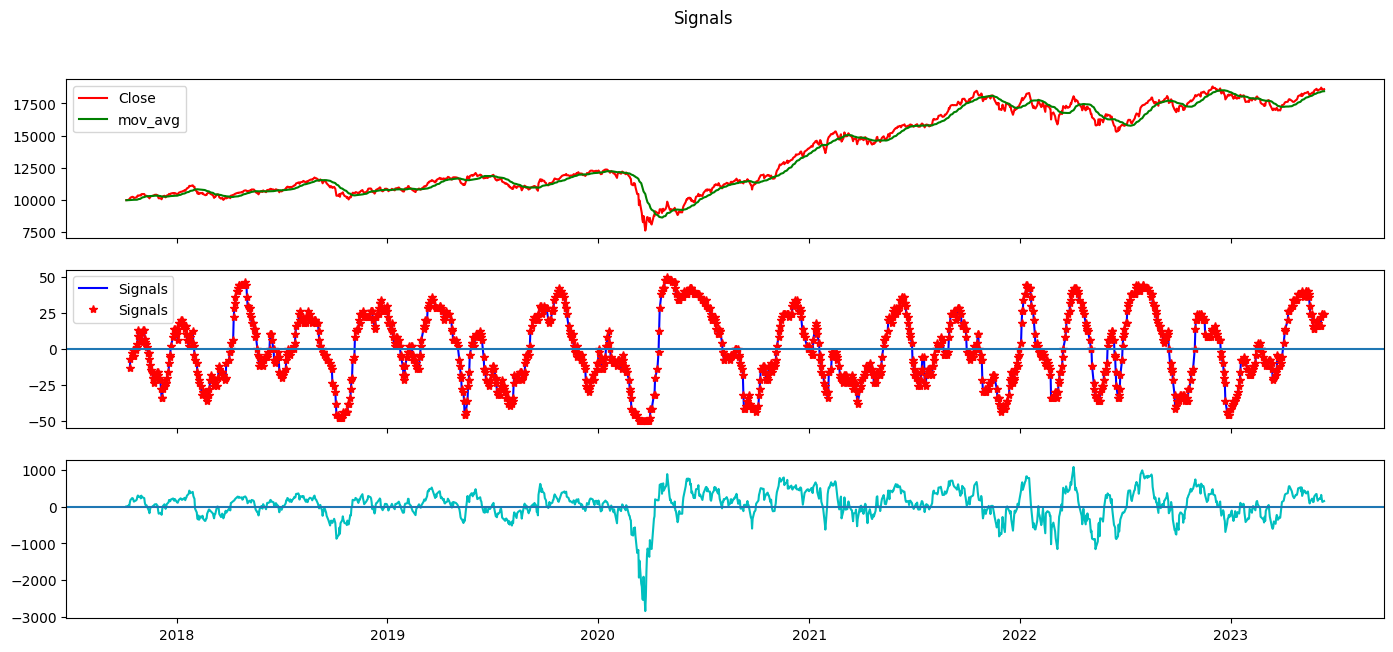

In [35]:
fig, ax = plt.subplots(3,1,figsize=(17,7),sharex=True)
ax[0].plot(nifty.loc[:, :].index, nifty.loc[:, 'Close'],'r', label='Close')
ax[0].plot(nifty.loc[:, :].index, nifty.loc[:, 'avg_mov'],'g', label='mov_avg')
ax[1].plot(solution.loc[:, :].index, solution.loc[:, 'final'],'b', label='Signals')
ax[1].plot(solution.loc[:, :].index, solution.loc[:, 'final'],'r*', label='Signals')
ax[2].plot(nifty.loc[:, :].index,nifty.loc[:,'spread'],'c',label='Spread')
#ax[1].plot(nifty.iloc[:, :].index, nifty.loc[:, 'Close'], label='Nifty')
plt.suptitle('Signals')
ax[0].legend()
ax[1].legend()
ax[1].axhline(y=0)
ax[2].axhline(y=0)
plt.show()

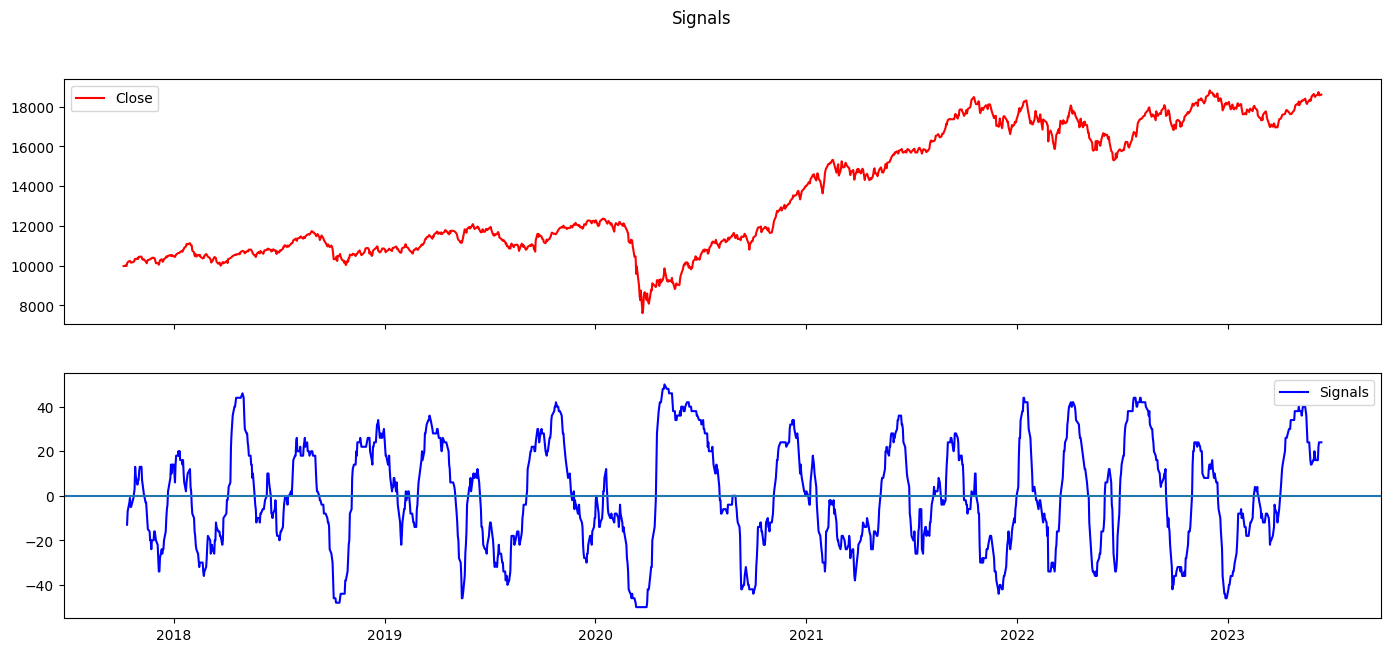

In [36]:
fig, ax = plt.subplots(2,1,figsize=(17,7),sharex=True)
ax[0].plot(nifty.loc[:, :].index, nifty.loc[:, 'Close'],'r', label='Close')
ax[1].plot(solution.loc[:, :].index, solution.loc[:, 'final'],'b', label='Signals')
#ax[1].plot(solution.iloc[:, :].index, solution.loc[:, 'avg_mov'], label='Moving_Average')
plt.suptitle('Signals')
ax[0].legend()
ax[1].legend()
ax[1].axhline(y=0)
plt.show()

In [37]:
new=pd.DataFrame()

In [38]:
new['signal_high'] = np.where((nifty['Close']>nifty['avg_mov']) & (solution['final']>solution['avg_mov']),1,0)

In [39]:
new['signal_low'] = np.where((nifty['Close']<nifty['avg_mov']) & (solution['final']<solution['avg_mov']),-1,0)

In [40]:
new['signal_final']=new['signal_high']+new['signal_low']

In [41]:
#pd.concat([solution.reset_index(),new[-4:]],axis=0)

In [42]:
l=400

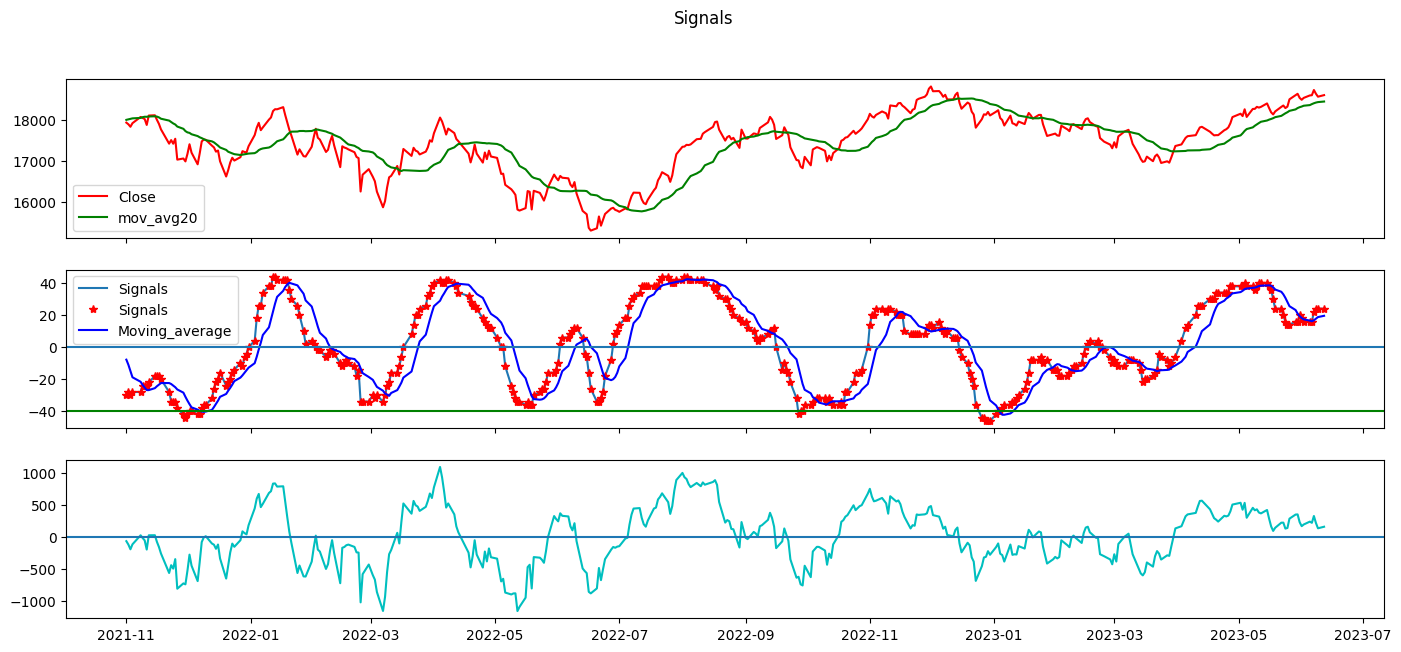

In [43]:
fig, ax = plt.subplots(3,1,figsize=(17,7),sharex=True)
ax[0].plot(nifty.loc[:, :].index[-l:], nifty.loc[:, 'Close'][-l:],'r', label='Close')
ax[0].plot(nifty.loc[:, :].index[-l:], nifty.loc[:, 'avg_mov'][-l:],'g', label='mov_avg20')
ax[1].plot(solution.loc[:, :].index[-l:], solution.loc[:, 'final'][-l:], label='Signals')
ax[1].plot(solution.loc[:, :].index[-l:], solution.loc[:, 'final'][-l:],'r*', label='Signals')
ax[1].plot(solution.iloc[:, :].index[-l:], solution.loc[:, 'avg_mov'][-l:],'b',label='Moving_average')
ax[2].plot(nifty.loc[:, :].index[-l:],nifty.loc[:,'spread'][-l:],'c',label='Spread')
#ax[3].plot(new.loc[:,:].index[-l:],new.loc[:,'signal_final'][-l:])
plt.suptitle('Signals')
ax[0].legend()
ax[1].legend(loc='upper left')
ax[1].axhline(y=0)
ax[2].axhline(y=0)
ax[1].axhline(y=-40,color='g')
plt.show()

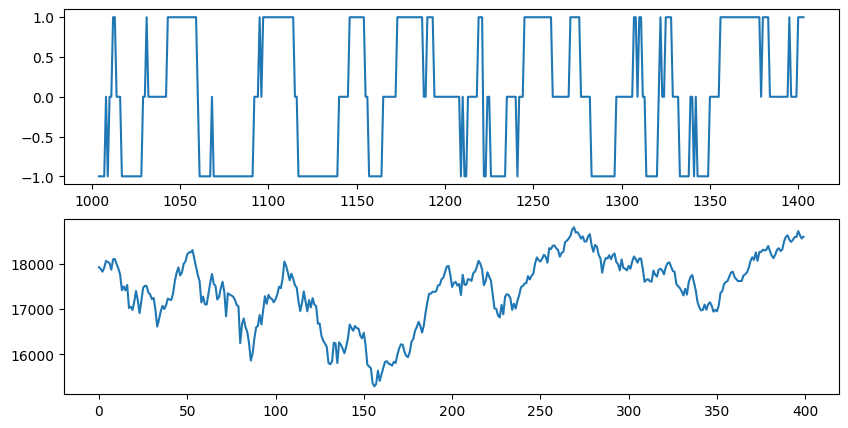

In [44]:
fig, ax = plt.subplots(2,1,figsize=(10,5),sharex=False)
ax[0].plot(new['signal_final'][-l:])
ax[1].plot(nifty['Close'][-l:].values)
plt.show()

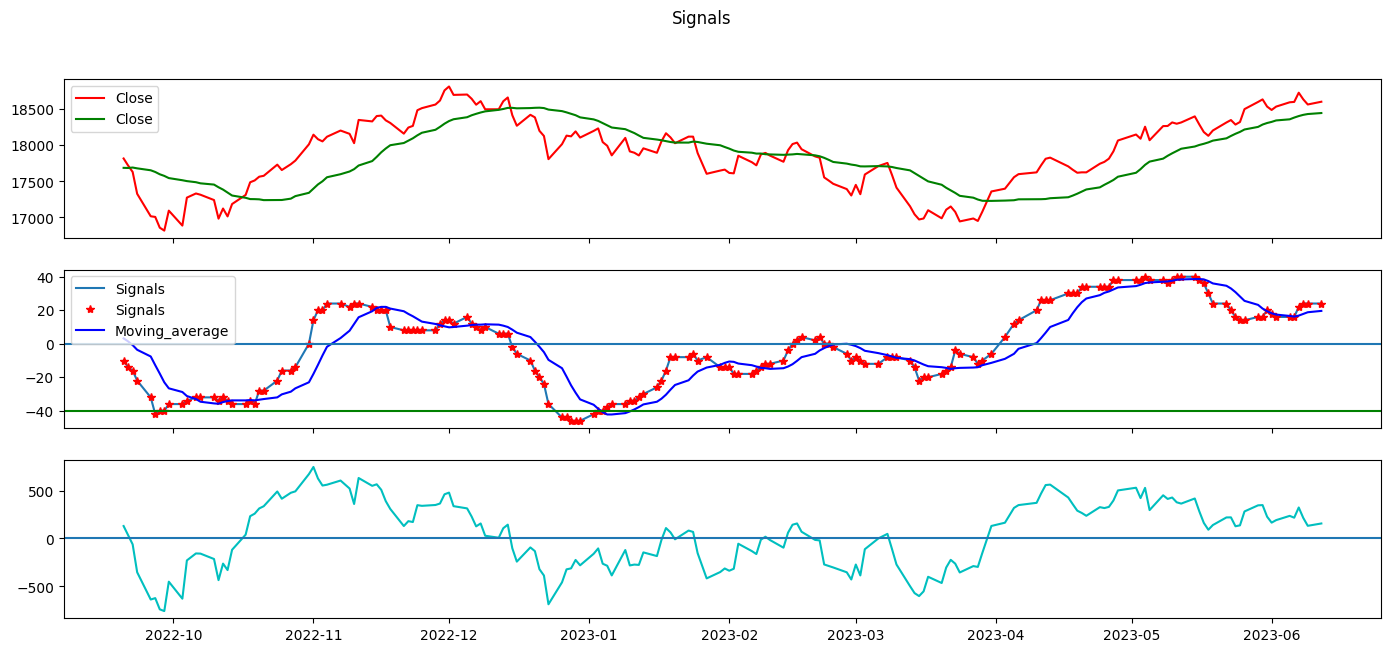

In [45]:
l=180
fig, ax = plt.subplots(3,1,figsize=(17,7),sharex=True)
ax[0].plot(nifty.loc[:, :].index[-l:], nifty.loc[:, 'Close'][-l:],'r', label='Close')
ax[0].plot(nifty.loc[:, :].index[-l:], nifty.loc[:, 'avg_mov'][-l:],'g', label='Close')
ax[1].plot(solution.loc[:, :].index[-l:], solution.loc[:, 'final'][-l:], label='Signals')
ax[1].plot(solution.loc[:, :].index[-l:], solution.loc[:, 'final'][-l:],'r*', label='Signals')
ax[1].plot(solution.iloc[:, :].index[-l:], solution.loc[:, 'avg_mov'][-l:],'b',label='Moving_average')
ax[2].plot(nifty.loc[:, :].index[-l:],nifty.loc[:,'spread'][-l:],'c',label='Spread')

plt.suptitle('Signals')
ax[0].legend()
ax[1].legend(loc='upper left')
ax[1].axhline(y=0)
ax[2].axhline(y=0)
ax[1].axhline(y=-40,color='g')
plt.show()

In [46]:
solution['signals']=np.where(solution['final']>0,1,-1)

In [47]:
print('change in nifty from yesterday' ,(nifty.Close.iloc[-1]-nifty.Close.iloc[-2])/nifty.Close.iloc[-2]*100)

change in nifty from yesterday 0.20524046550351463


In [48]:
nifty.Close.iloc[-1]

18601.5